# Hands-on session: Machine Learning & Data Visualization
---
## 2 - Fitting ML models
---


How do I run this?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sina-mansour/OHBM-Brainhack-2021)

Gitpod?

Binder?

---

package installation for google colab:

In [ ]:
# install required packages for colab
!pip install -r ../colab/requirements.txt


---

Loading packages

In [1]:
# pandas for data handling
import pandas as pd

# matplotlib and seaborn for data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# setup inline plotting for jupyter
%matplotlib inline

# numpy for mathematical operations of data
import numpy as np

# nilearn and nibabel for handling neuroimaging data
import nilearn.datasets as nidata
import nilearn.plotting as niplot
import nibabel as nib

# sklearn is python's base of operations for everything ML
import sklearn

# statsmodels is more of an statistical inference toolbox for python
import statsmodels



---

## Train-Test splitting; data leakage!

Before we begin our journey of Machine learning, we need understand the very basic terminologies on **samples** and **features**. We also need to cover what we mean by train vs. test splitting, and how it should be implemented.

### Representation of Data in [Scikit-learn](https://github.com/scikit-learn/scikit-learn)

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a **two-dimensional array or matrix**. The arrays can be either ``numpy`` arrays, or pandas ``dataframe`` objects, or in some cases ``scipy.sparse`` matrices. The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify). A sample can be a document, a picture, a sound, a video, an astronomical object, a row in database or CSV file, or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each item in a quantitative manner.  Features are generally real-valued, but may be boolean or discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional (e.g. millions of features) with most of them being zeros for a given sample. This is a case where `scipy.sparse` matrices can be useful, in that they are much more memory-efficient than numpy arrays.

<img src="../static/image6.png" alt="Data Layout" style="width: 600px;"/>

(Figure from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook))

Now, let's try and extract the features matrix from the abide data for later use.

In [2]:
# load the data from file
data = pd.read_csv('../data/abide2.tsv', sep='\t')

# inspect the first few rows
data.head()


,site,subject,age,age_resid,sex,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,13.642852,2.0,1.0,2750.0,306.0,354.0,2123.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,16.081732,2.0,1.0,2836.0,186.0,354.0,2261.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,12.866264,1.0,2.0,3394.0,223.0,373.0,2827.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,13.698139,1.0,1.0,3382.0,266.0,422.0,2686.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,14.772459,2.0,2.0,3080.0,161.0,346.0,2105.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


We aim to use the brain data as the training feature set:

In [3]:
# The filter() method allows us to select variables by name--
# in this case, we put all features that match 'fs' in X_all.
X_all = data.filter(like='fs')

X_all.head()

,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,fsArea_L_3b_ROI,fsArea_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,2750.0,306.0,354.0,2123.0,1451.0,1128.0,269.0,1751.0,1338.0,632.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,2836.0,186.0,354.0,2261.0,1584.0,1241.0,259.0,1521.0,1105.0,302.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,3394.0,223.0,373.0,2827.0,1816.0,1299.0,221.0,1657.0,1374.0,456.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3382.0,266.0,422.0,2686.0,1893.0,1359.0,234.0,1889.0,1545.0,407.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,3080.0,161.0,346.0,2105.0,1307.0,1004.0,254.0,1334.0,985.0,315.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


In [24]:
# for the sake of simplicity we'll only use a portion of the whole feature set
N_FEATURES = 5

# pandas DFs have a helpful sample() method for sampling rows/columns
X_sample = X_all.sample(N_FEATURES, axis=1, random_state=100)

X_sample.head()

,fsCT_R_a24_ROI,fsArea_R_d32_ROI,fsCT_L_PBelt_ROI,fsLGI_L_POS2_ROI,fsVol_L_FOP1_ROI
0,3.392,358.0,2.564,641.23,434.0
1,3.548,302.0,2.673,715.53,585.0
2,2.834,581.0,2.939,708.54,519.0
3,2.940,473.0,2.437,828.24,646.0
4,3.859,435.0,2.852,812.84,662.0


### Train-Test Splitting

The train-test split is a technique for evaluating the performance of a machine learning algorithm. It's a method that is mainly used for evaluation of supervised learning tasks.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the **training dataset**. The second subset is *not used to train the model*. In fact, it should be left untouched and unseen. This subset will be used to investigate the performance of the predictions. This second dataset is referred to as the test dataset.

- Train Dataset: Used to fit the machine learning model.
- Test Dataset: Used to evaluate the model fit.

<img src="../static/image7.png" alt="Split structure" style="width: 900px;"/>


#### Data leakage in machine learning

Data leakage is a big problem in machine learning when developing predictive models. Data leakage is a term used to refer to when information from outside the training dataset (usually from the test dataset) is used for model fitting. Data leakage generally results in inflated performance evaluation.



Let's do the train-test splitting from the beginning so that we're sure, there will be no data leakage. (We will not use the test split until evaluation steps.)

In [28]:
# A fixed random seed for reproducibility
split_random_seed = 123

# Split feature set
X_sample_train, X_sample_test = sklearn.model_selection.train_test_split(X_sample, test_size=200, random_state=split_random_seed)

# Let's ensure sizes are valid
print(f'Train dataset shape: {X_sample_train.shape}\nTest dataset shape: {X_sample_test.shape}')


Train dataset shape: (804, 5)
Test dataset shape: (200, 5)


In [29]:
# Split the demographic information for later
age = data['age']
sex = data['sex']
group = data['group']

age_train, age_test = sklearn.model_selection.train_test_split(age, test_size=200, random_state=split_random_seed)
sex_train, sex_test = sklearn.model_selection.train_test_split(sex, test_size=200, random_state=split_random_seed)
group_train, group_test = sklearn.model_selection.train_test_split(group, test_size=200, random_state=split_random_seed)


---
## Estimators and cost functions

### Estimators in scikit-learn: Basic usage
One of scikit-learn's most attractive features is its unified, simple interface for configuring estimators and fitting models. A good deal of the package consists of a very large set of `Estimator` classes you can use to do various forms of machine learning. In scikit-learn, an `Estimator` does exactly what the word *estimator* normally means in statistics: it implements ["a rule for calculating an estimate of a given quantity based on observed data"](https://en.wikipedia.org/wiki/Estimator).

While scikit-learn includes hundreds of different estimators that generate predictions in very different ways, they all share a common interface (or *API*). In particular, every estimator class implements `.fit()` and `.predict()` methods. When we call an estimator's `.fit()` method, we're telling it to take some training data—including a mandatory `X` matrix, and an optional `y` vector (if it's a supervised estimator)—and do something with it. In cases where `y` is present, the estimator is generally trying to learn how to predict the values of `y` from the values in `X`. Once it's done that, we can then call `predict()`, which takes another `X` matrix (either the same one as before, or a different one) and predicts corresponding `y` scores.

A list of various estimators available through sklearn can be found [here](https://scikit-learn.org/stable/modules/classes.html). Selecting the appropriate estimator is a key step, and it usually creates a large degree of freedom for the researcher. Usually, prior knowledge about the features can help in choosing the estimator. However, some general rule of thumb recommendations exist too:

<img src="../static/image8.png" alt="Estimator selection" style="width: 900px;"/>

(Figure from the [Sci-Kit learn's machine learning tutorial](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html))


---
## Regression estimators

As explained previously, regression is a supervised learning approch to predict continuous data, i.e. the train dataset is used to learn the relationship between the feature set and a variable of interest.

A regression problem arises any time we have a set of continuous numerical labels, and we're interested in using one or more features to try and predict those labels. Any bivariate relationship can be conceptualized as a regression of one variable on the other. For example, suppose we have the data displayed in this scatterplot:

Text(0, 0.5, 'y')

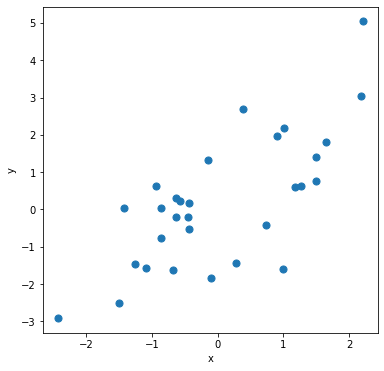

In [37]:
# fix seed to produce deterministic results
np.random.seed(123)

x = np.random.normal(size=30)
y = x * 1.2 + np.random.normal(size=30)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(x, y, s=50)
plt.xlabel('x')
plt.ylabel('y')


We can frame this as a regression problem by saying that our goal is to generate the best possible prediction for `y` given knowledge of `x`.

For instance, we can try to find a *linear* relationship that can predict y from x:

Text(0, 0.5, 'y')

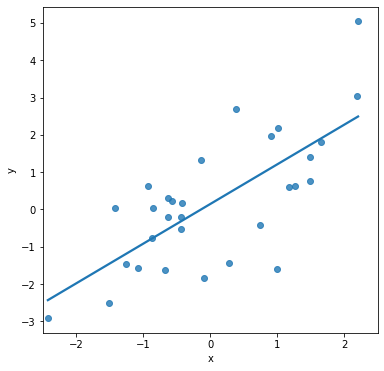

In [57]:
# fix seed to produce deterministic results
np.random.seed(123)

x = np.random.normal(size=30)
y = x * 1.2 + np.random.normal(size=30)

fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(data=pd.DataFrame(np.array([x,y]).T, columns=['x','y']), x='x', y='y', ax=ax, ci=None)
ax.set_xlim([-2.5,2.5])
plt.xlabel('x')
plt.ylabel('y')


In our data, we are interested in predicting age from brain data. This concept is formally known as brain-age prediction.

We can see how a measure of cortical thickness changes by age:

<AxesSubplot:xlabel='age', ylabel='fsVol_L_FOP1_ROI'>

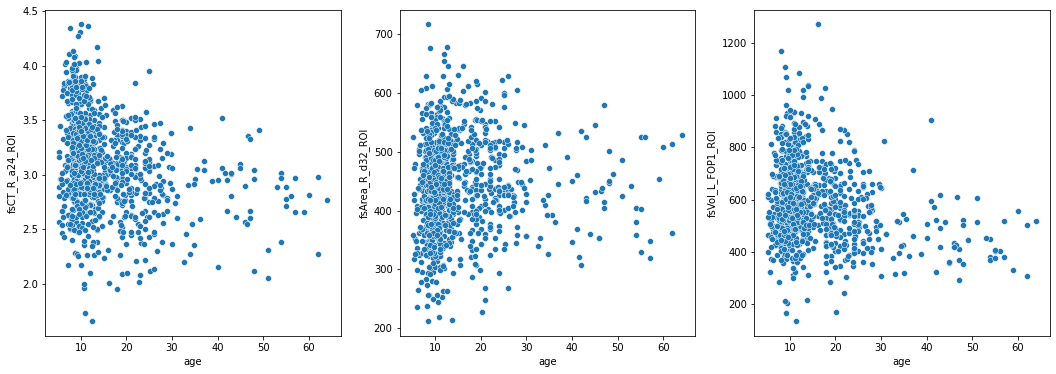

In [66]:
# create a figure
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# scatter brain data vs. age
sns.scatterplot(y=data['fsCT_R_a24_ROI'], x=data['age'], ax=axes[0])
sns.scatterplot(y=data['fsArea_R_d32_ROI'], x=data['age'], ax=axes[1])
sns.scatterplot(y=data['fsVol_L_FOP1_ROI'], x=data['age'], ax=axes[2])


The relationship is not as clear as it is with simulated data. However, we hope that we could exploit the capabilities of machine learning to predict an individual's age from a collective of brain information.

Let's start with a simple model, and see how it goes:

### Applying the LinearRegression() estimator
To see this in action, let's try out one particular estimator in scikit-learn: "ordinary" least-squares (OLS) regression.



---
## Classification estimators


---
## Clustering estimators

---
## Dimensionality reduction estimators
